### Importing cleaned dataframes 

In [1]:
import pandas as pd
import logging
import sys
import numpy as np
from dataclasses import asdict
from pathlib import Path

sys.path.append(r"C:\Users\giuli\Repositories\intraday-momentum\src")
sys.path.append("/home/corwyn/Black_swan/Intraday_project/intraday-momentum/src")
from classes.metrics.metrics import MetricsCalculator
from classes.backtest.engine import BacktestEngine  
from classes.backtest.default import BacktestDefaults 

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    force=True,   # <-- allow printing in jupyter notebooks
)

logger = logging.getLogger(__name__)


In [2]:
# Load files
"""df_spy = pd.read_pickle("C:\\Users\\giuli\\Repositories\\intraday-momentum\\data\\cleaned\\SPY_1min_20231027_20251027.pkl")  
df_vixx = pd.read_pickle("C:/Users/giuli/Repositories/intraday-momentum/data/cleaned/^VIX_1day_20231027_20251027.pkl")
df_dividends = pd.read_csv("C:\\Users\\giuli\\Repositories\\intraday-momentum\\data\\cleaned\\SPY_dividends_20231027_20250919.csv")
df_spy_daily = pd.read_pickle("C:/Users/giuli/Repositories/intraday-momentum/data/cleaned/SPY_daily_from27-10-2023.pkl")
"""


df_vixx = pd.read_pickle("/home/corwyn/Black_swan/Intraday_project/intraday-momentum/data/cleaned/^VIX_1day_20231027_20251027.pkl")  
df_spy = pd.read_pickle("/home/corwyn/Black_swan/Intraday_project/intraday-momentum/data/cleaned/SPY_1min_20231027_20251027.pkl")
df_dividends = pd.read_csv("/home/corwyn/Black_swan/Intraday_project/intraday-momentum/data/cleaned/SPY_dividends_20231027_20250919.csv")
df_spy_daily = pd.read_pickle("/home/corwyn/Black_swan/Intraday_project/intraday-momentum/data/cleaned/SPY_daily_from27-10-2023.pkl")

# Print information about the dataframes
df_spy.info()
print("\n")
df_vixx.info()
print("\n")
df_dividends.info()
print("\n")
df_spy_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194105 entries, 2023-10-30 09:30:00 to 2025-10-27 15:59:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   volume  194105 non-null  float64
 1   open    194105 non-null  float64
 2   high    194105 non-null  float64
 3   low     194105 non-null  float64
 4   close   194105 non-null  float64
dtypes: float64(5)
memory usage: 8.9 MB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-10-27 05:00:00+00:00 to 2025-10-24 05:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  500 non-null    int64  
 1   open    500 non-null    float64
 2   high    500 non-null    float64
 3   low     500 non-null    float64
 4   close   500 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 23.4 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (t

In [3]:
dfs = {
    "df_spy": df_spy,
    "df_vixx": df_vixx,
    "df_spy_daily": df_spy_daily,
}

for name, df in dfs.items():
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError(f"{name}: index must be a DatetimeIndex.")
    else:
        logger.info(f"{name}: index is a valid DatetimeIndex with timezone={df.index.tz}.")


2025-12-01 18:39:52,566 | INFO | df_spy: index is a valid DatetimeIndex with timezone=None.
2025-12-01 18:39:52,568 | INFO | df_vixx: index is a valid DatetimeIndex with timezone=UTC.
2025-12-01 18:39:52,569 | INFO | df_spy_daily: index is a valid DatetimeIndex with timezone=None.


Two dfs have no timezone, so we need to make sure everything is uniform.

In [4]:
dfs = {
    "df_spy": df_spy,
    "df_vixx": df_vixx,
    "df_spy_daily": df_spy_daily
}

for name, df in dfs.items():
    # Ensure index is DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Localize naive timestamps (assuming US/Eastern for intraday and daily SPY; VIX depends)
    if df.index.tz is None:
        if name in ["df_spy", "df_spy_daily"]:
            df.index = df.index.tz_localize("US/Eastern")
        else:  
            df.index = df.index.tz_localize("UTC")  

    # Convert to common timezone UTC
    df.index = df.index.tz_convert("UTC")

    # Assign back to dict
    dfs[name] = df

    # Log result
    if isinstance(df.index, pd.DatetimeIndex):
        logger.info(f"{name}: index is a valid DatetimeIndex (tz={df.index.tz})")
    else:
        logger.warning(f"{name}: index is NOT a DatetimeIndex (type={type(df.index)})")

#reassign to original variables
df_spy = dfs["df_spy"]
df_vixx = dfs["df_vixx"]
df_spy_daily = dfs["df_spy_daily"]


2025-12-01 18:39:52,619 | INFO | df_spy: index is a valid DatetimeIndex (tz=UTC)
2025-12-01 18:39:52,625 | INFO | df_vixx: index is a valid DatetimeIndex (tz=UTC)
2025-12-01 18:39:52,627 | INFO | df_spy_daily: index is a valid DatetimeIndex (tz=UTC)


### Add key variables

In [5]:
df_spy[500:510]


,volume,open,high,low,close
Datetime,,,,,
2023-10-31 15:20:00+00:00,114037.0,416.035,416.07,415.8300,415.88
2023-10-31 15:21:00+00:00,113127.0,415.880,415.99,415.7200,415.80
2023-10-31 15:22:00+00:00,133653.0,415.800,415.94,415.7650,415.91
2023-10-31 15:23:00+00:00,73109.0,415.910,415.91,415.7350,415.77
2023-10-31 15:24:00+00:00,168774.0,415.780,415.79,415.6002,415.75
2023-10-31 15:25:00+00:00,128031.0,415.760,416.06,415.6800,415.98
2023-10-31 15:26:00+00:00,136299.0,415.980,416.33,415.9800,416.30
2023-10-31 15:27:00+00:00,102300.0,416.320,416.35,416.1300,416.27
2023-10-31 15:28:00+00:00,83196.0,416.270,416.31,416.1006,416.13


In [6]:
# Ensure df_spy index is DatetimeIndex
if not isinstance(df_spy.index, pd.DatetimeIndex):
    df_spy.index = pd.to_datetime(df_spy.index)

# Add 'day' column for dividends merge
df_spy["day"] = df_spy.index.date

project_root = Path().resolve().parents[0]  # adjust if needed
data_path = project_root / "data" / "cleaned" / "SPY_dividends_20231027_20250919.csv"

dividends = pd.read_csv(data_path)

dividends["caldt"] = pd.to_datetime(dividends["caldt"]).dt.date

In [7]:
df_spy

,volume,open,high,low,close,day
Datetime,,,,,,
2023-10-30 13:30:00+00:00,630285.0,413.560,413.940,413.530,413.770,2023-10-30
2023-10-30 13:31:00+00:00,322290.0,413.780,414.010,413.750,413.882,2023-10-30
2023-10-30 13:32:00+00:00,455364.0,413.910,414.210,413.845,414.140,2023-10-30
2023-10-30 13:33:00+00:00,269190.0,414.130,414.240,414.050,414.205,2023-10-30
2023-10-30 13:34:00+00:00,330914.0,414.205,414.320,414.205,414.270,2023-10-30
...,...,...,...,...,...,...
2025-10-27 19:55:00+00:00,826675.0,685.490,685.520,685.280,685.395,2025-10-27
2025-10-27 19:56:00+00:00,670327.0,685.390,685.540,685.380,685.460,2025-10-27
2025-10-27 19:57:00+00:00,832993.0,685.460,685.460,685.345,685.415,2025-10-27


In [8]:
# Compute metrics
mc = MetricsCalculator()
df_spy, df_spy_daily= mc.from_clean_df(df_spy , dividends)
mc.quality_check(df_spy, df_spy_daily)

mc.logger.info("All SPY metrics successfully computed.")

df_spy.head()


2025-12-01 18:39:52,849 | INFO | Starting computation of market microstructure metrics...
2025-12-01 18:39:56,087 | INFO | Running quality checks...
2025-12-01 18:39:56,102 | INFO | NaN summary:
log_returns    1
RV             0
BV             0
vwap           0
price          0
day            0
dtype: int64
2025-12-01 18:39:56,103 | INFO | df_all_days shape: (194105, 21)
2025-12-01 18:39:56,104 | INFO | df_daily_profiles shape: (194105, 22)
2025-12-01 18:39:56,336 | INFO | df_all saved to data/processed/df_all_days.pkl
2025-12-01 18:39:56,577 | INFO | df_daily saved to data/processed/df_daily_groups.pkl
2025-12-01 18:39:56,578 | INFO | Running quality checks...
2025-12-01 18:39:56,593 | INFO | NaN summary:
log_returns    1
RV             0
BV             0
vwap           0
price          0
day            0
dtype: int64
2025-12-01 18:39:56,595 | INFO | df_all_days shape: (194105, 21)
2025-12-01 18:39:56,596 | INFO | df_daily_profiles shape: (194105, 22)
2025-12-01 18:39:56,596 | INFO |

,timestamp,volume,open,high,low,close,day,log_returns,RV,BV,...,vwap,hlc,move_open,spy_dvol,spy_ret,min_from_open,minute_of_day,move_open_rolling_mean,sigma_open,dividend
0,2023-10-30 13:30:00+00:00,630285.0,413.560,413.94,413.530,413.770,2023-10-30,NaN,0.006868,0.000031,...,413.746667,413.746667,0.000508,NaN,NaN,241.0,241,NaN,NaN,0.0
1,2023-10-30 13:31:00+00:00,322290.0,413.780,414.01,413.750,413.882,2023-10-30,0.000271,0.006868,0.000031,...,413.792004,413.880667,0.000779,NaN,NaN,242.0,242,NaN,NaN,0.0
2,2023-10-30 13:32:00+00:00,455364.0,413.910,414.21,413.845,414.140,2023-10-30,0.000623,0.006868,0.000031,...,413.880298,414.065000,0.001402,NaN,NaN,243.0,243,NaN,NaN,0.0
3,2023-10-30 13:33:00+00:00,269190.0,414.130,414.24,414.050,414.205,2023-10-30,0.000157,0.006868,0.000031,...,413.925994,414.165000,0.001560,NaN,NaN,244.0,244,NaN,NaN,0.0
4,2023-10-30 13:34:00+00:00,330914.0,414.205,414.32,414.205,414.270,2023-10-30,0.000157,0.006868,0.000031,...,413.981860,414.265000,0.001717,NaN,NaN,245.0,245,NaN,NaN,0.0


In [9]:
df_spy.info()
df_spy.describe()
df_spy.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194105 entries, 0 to 194104
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   timestamp               194105 non-null  datetime64[ns, UTC]
 1   volume                  194105 non-null  float64            
 2   open                    194105 non-null  float64            
 3   high                    194105 non-null  float64            
 4   low                     194105 non-null  float64            
 5   close                   194105 non-null  float64            
 6   day                     194105 non-null  object             
 7   log_returns             194104 non-null  float64            
 8   RV                      194105 non-null  float64            
 9   BV                      194105 non-null  float64            
 10  price                   194105 non-null  float64            
 11  vwap                    19

timestamp                    0
volume                       0
open                         0
high                         0
low                          0
close                        0
day                          0
log_returns                  1
RV                           0
BV                           0
price                        0
vwap                         0
hlc                          0
move_open                    0
spy_dvol                  5850
spy_ret                    390
min_from_open                0
minute_of_day                0
move_open_rolling_mean    5400
sigma_open                5850
dividend                     0
dtype: int64

In [10]:

defaults = BacktestDefaults(
    minute_path="/home/corwyn/Black_swan/Intraday_project/intraday-momentum/notebooks/data/processed/df_all_days.pkl",
    daily_path="/home/corwyn/Black_swan/Intraday_project/intraday-momentum/notebooks/data/processed/df_daily_groups.pkl",
    initial_aum=100_000.0,
    commission_rate=0.0035,
    min_comm_per_order=0.35,
    slippage_bps=0,
    band_mult=1.0,
    trade_freq=30,
    sizing_type="vol_target",
    target_vol=0.02,
    max_leverage=4.0,
)

engine = BacktestEngine()
trade_log_df, daily_pnl_df, equity_curve_df = engine.run_backtest(asdict(defaults))

[WARNING] Daily data at '/home/corwyn/Black_swan/Intraday_project/intraday-momentum/notebooks/data/processed/df_daily_groups.pkl' is missing required columns: 'caldt' and/or 'close'.


2025-12-01 18:39:59,487 | INFO | Trade log saved to /home/corwyn/Black_swan/Intraday_project/intraday-momentum/src/data/processed/trade_log.csv
2025-12-01 18:39:59,488 | INFO | Daily PnL saved to /home/corwyn/Black_swan/Intraday_project/intraday-momentum/src/data/processed/daily_pnl.pkl


<function matplotlib.pyplot.show(close=None, block=None)>

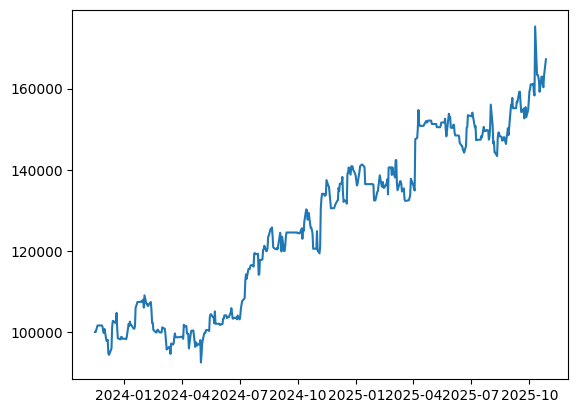

In [19]:
from classes.viz.plotter import Plotter
#No way no

import matplotlib.pyplot as plt
data = pd.read_pickle("/home/corwyn/Black_swan/Intraday_project/intraday-momentum/src/data/processed/daily_pnl.pkl")

plt.plot(data.index, data["AUM"])
plt.show